## Google Colab setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
from pathlib import Path
import numpy as np
import cv2
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import random
import os

In [3]:
from generators import NoisyImageTrainGenerator, NoisyImageValGenerator
import utils, noise_models
from unet_n2n import get_unet_model

## Initialise data

In [4]:
TRAIN_IMAGE_DIR = "drive/MyDrive/imagenet-10k"
VAL_IMAGE_DIR = "drive/MyDrive/BSDS300/images/train"
TEST_IMAGE_DIR = "drive/MyDrive/BSDS300/images/test"
DATA_BATCH_SIZE = 16

In [5]:
source_noise_model = noise_models.gaussian_noise
target_noise_model = noise_models.gaussian_noise
val_noise_model = noise_models.gaussian_noise

In [6]:
training_gen = NoisyImageTrainGenerator(
    image_dir=TRAIN_IMAGE_DIR,
    input_noise_model=source_noise_model,
    target_noise_model=target_noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=256
)

validation_gen = NoisyImageValGenerator(
    image_dir=VAL_IMAGE_DIR,
    val_noise_model=val_noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=256
)

## Initialise model

In [7]:
class SaveModelEveryEpoch(keras.callbacks.Callback):
    def __init__(self, save_dir="model_checkpoints"):
        """
        A Keras callback to save the model at the end of every epoch.

        Args:
            save_dir (str): Directory where models will be saved.
        """
        super(SaveModelEveryEpoch, self).__init__()
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)  # Create directory if it doesn't exist

    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch. Saves the model.

        Args:
            epoch (int): The current epoch number.
            logs (dict): Metrics and loss values from the current epoch.
        """
        filename = os.path.join(self.save_dir, f"model_epoch_{epoch + 1}.keras")
        self.model.save(filename)
        print(f"\nModel saved at: {filename}")

save_model_callback = SaveModelEveryEpoch(save_dir="drive/MyDrive/saved_models")

In [8]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [9]:
model = get_unet_model(input_shape=(256, 256, 3), classes=3)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.99, epsilon=1e-8),
    loss=keras.losses.MeanSquaredError(),
    metrics=[psnr],
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


## Train model

In [10]:
history = model.fit(
    training_gen,
    validation_data=validation_gen,
    batch_size=4,
    epochs=20,
    verbose=2,
    callbacks=[save_model_callback]
)

Epoch 1/20

Model saved at: drive/MyDrive/saved_models/model_epoch_1.keras
625/625 - 347s - 555ms/step - loss: 0.0285 - psnr: 16.9220 - val_loss: 0.0062 - val_psnr: 22.5530
Epoch 2/20

Model saved at: drive/MyDrive/saved_models/model_epoch_2.keras
625/625 - 217s - 347ms/step - loss: 0.0154 - psnr: 19.1503 - val_loss: 0.0033 - val_psnr: 25.5780
Epoch 3/20

Model saved at: drive/MyDrive/saved_models/model_epoch_3.keras
625/625 - 218s - 348ms/step - loss: 0.0141 - psnr: 19.7629 - val_loss: 0.0028 - val_psnr: 26.4890
Epoch 4/20

Model saved at: drive/MyDrive/saved_models/model_epoch_4.keras
625/625 - 218s - 348ms/step - loss: 0.0135 - psnr: 20.0476 - val_loss: 0.0024 - val_psnr: 27.2034
Epoch 5/20

Model saved at: drive/MyDrive/saved_models/model_epoch_5.keras
625/625 - 217s - 347ms/step - loss: 0.0133 - psnr: 20.1913 - val_loss: 0.0023 - val_psnr: 27.4071
Epoch 6/20

Model saved at: drive/MyDrive/saved_models/model_epoch_6.keras
625/625 - 218s - 349ms/step - loss: 0.0129 - psnr: 20.3794 -

In [11]:
model.save("n2n_unet_imagenet-50k.keras")

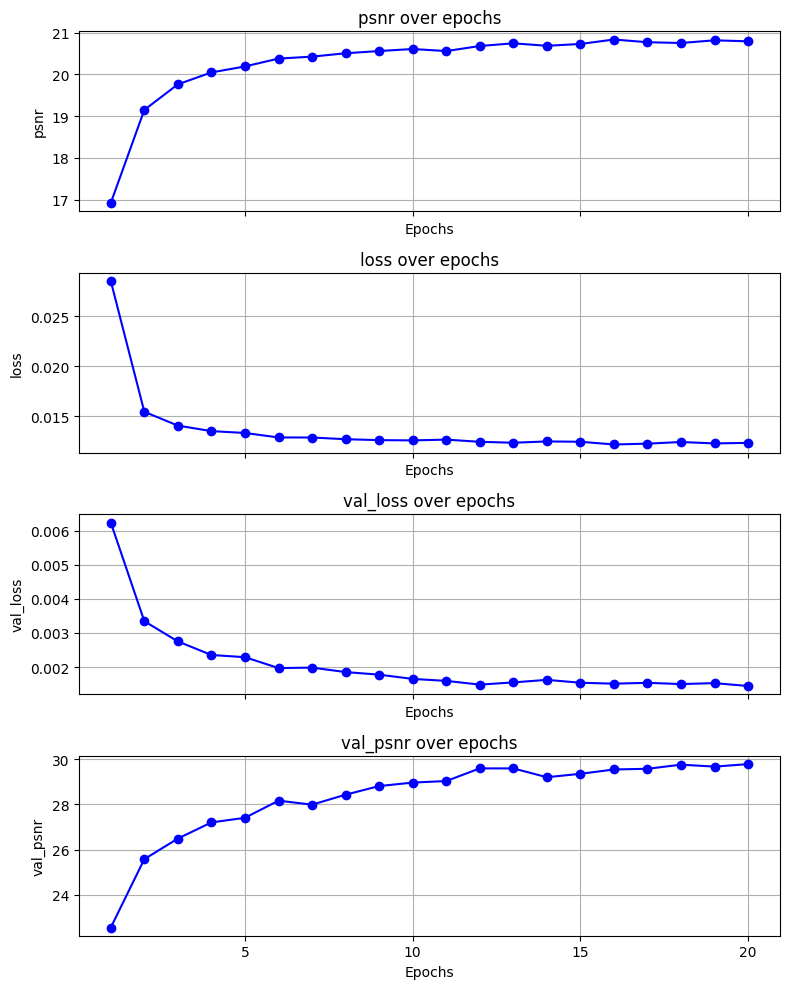

In [12]:
fig = utils.get_history_curve(history, metrics=["psnr", "loss", "val_loss", "val_psnr"])

## Evaluate model

In [13]:
test_noise_model = noise_models.gaussian_noise

In [14]:
import matplotlib.patches as patches

def process_and_visualize(image_dir, model, patch_size=256):
    # Get all image paths
    image_suffixes = ['.jpeg', '.png', '.jpg']
    all_image_paths = [p for p in Path(image_dir).glob("**/*") if p.suffix.lower() in image_suffixes]
    if not all_image_paths:
        raise ValueError(f"No images found in directory {image_dir}.")

    # Select a random image
    image_path = random.choice(all_image_paths)
    original_image = cv2.imread(str(image_path))
    if original_image is None:
        raise ValueError(f"Image at {image_path} could not be read.")
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    h, w, _ = original_image.shape
    if h < patch_size or w < patch_size:
        raise ValueError(f"Image size ({h}, {w}) is smaller than patch size {patch_size}.")

    # Select a random patch
    top_left_h = np.random.randint(0, h - patch_size + 1)
    top_left_w = np.random.randint(0, w - patch_size + 1)
    ground_truth_patch = original_image[top_left_h:top_left_h + patch_size, top_left_w:top_left_w + patch_size]

    # Add noise to the patch
    noisy_patch = test_noise_model(ground_truth_patch)

    # Normalise for model input
    normalised_noisy_patch = noisy_patch.astype(np.float32) / 255.0
    normalised_noisy_patch = np.expand_dims(normalised_noisy_patch, axis=0)

    # Denoise using the model
    denoised_patch = model.predict(normalised_noisy_patch)[0]
    denoised_patch = np.clip(denoised_patch, 0, 1) * 255.0
    denoised_patch = denoised_patch.astype(np.uint8)

    # Plot the results
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))

    # Plot the original image with the patch rectangle
    axes[0].imshow(original_image)
    axes[0].axis("off")
    axes[0].set_title("Original Image with Patch Highlighted")

    # Draw the rectangle on the original image
    rect = patches.Rectangle(
        (top_left_w, top_left_h), patch_size, patch_size, linewidth=2, edgecolor="orange", facecolor="none"
    )
    axes[0].add_patch(rect)

    # Plot the patches: noisy, denoised, and ground truth
    axes[1].imshow(np.hstack([ground_truth_patch, noisy_patch, denoised_patch]))
    axes[1].axis("off")
    axes[1].set_title("Ground Truth, Noisy, Denoised Patches")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


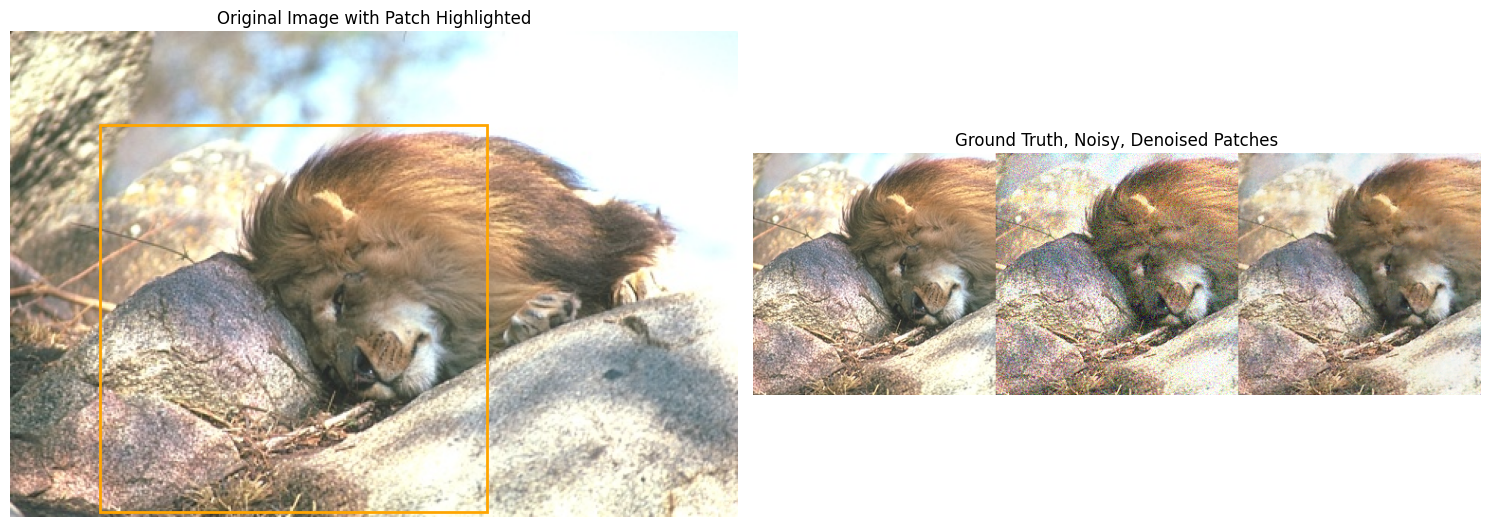

In [15]:
process_and_visualize(TEST_IMAGE_DIR, model)